# Simple Cycle Examples with BMS and DARTS
The aim of this example notebook is to use the AutoRA `Cycle` to recover a simple ground truth theory from some noisy data using BSM and DARTS, as a proof of concept.
It uses a trivial experimentalist which resamples the same x-values each cycle.

In [23]:
from autora.variable import VariableCollection, Variable
from autora.cycle import Cycle
import matplotlib.pyplot as plt
from itertools import repeat, chain

In [24]:
def ground_truth(xs):
    return (xs ** 2.) + xs + 1.

The space of allowed x values is the integers between 0 and 10 inclusive, and we record the allowed output values as well.

In [25]:
study_metadata = VariableCollection(
   independent_variables=[Variable(name="x1", allowed_values=range(11))],
   dependent_variables=[Variable(name="y", value_range=(-20, 20))],
   )

The experimentalist is used to propose experiments.
Since the space of values is so restricted, we can just sample them all each time.

In [26]:
from autora.experimentalist.pipeline import make_pipeline
example_experimentalist = make_pipeline(
    [list(chain.from_iterable((repeat(study_metadata.independent_variables[0].allowed_values, 10))))])

When we run a synthetic experiment, we get a reproducible noisy result:

In [27]:
import numpy as np

def get_example_synthetic_experiment_runner():
    rng = np.random.default_rng(seed=180)
    def runner(xs):
        return ground_truth(xs) + rng.normal(0, 1.0, xs.shape)
    return runner

example_synthetic_experiment_runner = get_example_synthetic_experiment_runner()
x = np.array([1.])
example_synthetic_experiment_runner(x)

array([3.4339546])

## Bayesian Machine Scientist

In [28]:
from autora.skl.bms import BMSRegressor
bms_theorist = BMSRegressor(epochs=100)

We initialize the Cycle with the metadata describing the domain of the theory,
the theorist, experimentalist and experiment runner,
as well as a monitor which will let us know which cycle we're currently on.

In [29]:
cycle = Cycle(
    metadata=study_metadata,
    theorist=bms_theorist,
    experimentalist=example_experimentalist,
    experiment_runner=example_synthetic_experiment_runner
)

We can run the cycle by calling the run method:

In [30]:
cycle.run(num_cycles=3)  # doctest: +ELLIPSIS

/Users/musslick/Library/Caches/pypoetry/virtualenvs/autora-EQvdzGGx-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:autora.skl.bms:BMS fitting started
<lambdifygenerated-11073>:2: RuntimeWarning: divide by zero encountered in log
  return log(X0)
<lambdifygenerated-11074>:2: RuntimeWarning: divide by zero encountered in log
  return log(X0)
<lambdifygenerated-11075>:2: RuntimeWarning: divide by zero encountered in log
  return log(X0)
INFO:autora.theorist.bms.utils:Finish iteration 0
INFO:autora.theorist.bms.utils:Finish iteration 1
INFO:autora.theorist.bms.utils:Finish iteration 2
<lambdifygenerated-11287>:2: RuntimeWarning: divide by zero encountered in divide
  return X0 + _a0_/X0
/Users/musslick/Library/Caches/pypoetry/virtualenvs/autora-EQvdzGGx-py3.9/lib/python3.9/site-

We can now interrogate the results. The first set of conditions which went into the
experiment runner were:

The observations include the conditions and the results:

In [19]:
cycle.data.observations[0]

array([[  0.        ,   0.26753453],
       [  1.        ,   1.9519928 ],
       [  2.        ,   7.87465709],
       [  3.        ,  12.30239434],
       [  4.        ,  20.54291019],
       [  5.        ,  31.47639884],
       [  6.        ,  45.07705741],
       [  7.        ,  55.5681519 ],
       [  8.        ,  73.57358232],
       [  9.        ,  92.87134065],
       [ 10.        , 109.85179055],
       [  0.        ,   1.79068258],
       [  1.        ,   3.40846155],
       [  2.        ,   8.05632443],
       [  3.        ,  11.79598753],
       [  4.        ,  19.89596531],
       [  5.        ,  30.08085308],
       [  6.        ,  45.65884618],
       [  7.        ,  56.37606692],
       [  8.        ,  72.39530056],
       [  9.        ,  89.94176643],
       [ 10.        , 111.10818029],
       [  0.        ,   1.85598268],
       [  1.        ,   4.43348924],
       [  2.        ,   5.87148322],
       [  3.        ,  15.03615098],
       [  4.        ,  23.10288785],
 

The best fit theory after the first cycle is:

In [20]:
str(cycle.data.theories[0].model_), cycle.data.theories[0].model_.fit_par[str(cycle.data.theories[0].model_)]

('((X0 * (_a0_ + X0)) + _a0_)', {'d0': {'_a0_': 0.9997263657404922}})

In [21]:
str(cycle.data.theories[-1].model_), cycle.data.theories[-1].model_.fit_par[str(cycle.data.theories[-1].model_)]

('((tanh(sig(sqrt(_a0_))) + X0) ** _a0_)', {'d0': {'_a0_': 1.987683442459932}})

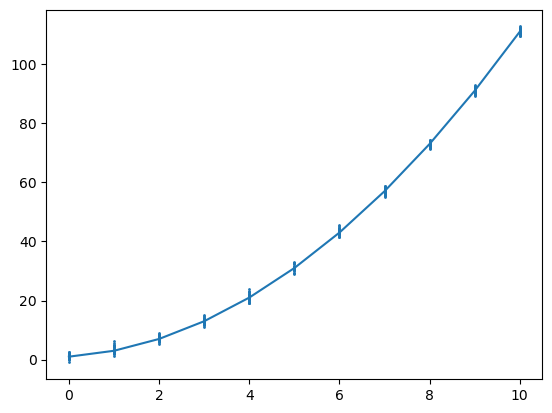

In [22]:
all_obs = np.row_stack(cycle.data.observations)
x_obs, y_obs = all_obs[:,0], all_obs[:,1]
plt.scatter(x_obs, y_obs, s=1)

x_pred = np.array(study_metadata.independent_variables[0].allowed_values).reshape(11, 1)
y_pred = cycle.data.theories[0].predict(x_pred)
plt.plot(x_pred, y_pred)

## DARTS


In [ ]:
from autora.skl.darts import DARTSRegressor
darts_theorist = DARTSRegressor(max_epochs=100)

In [ ]:
darts_cycle = Cycle(
    metadata=study_metadata,
    theorist=darts_theorist,
    experimentalist=example_experimentalist,
    experiment_runner=example_synthetic_experiment_runner
)

In [ ]:
darts_cycle.run(3)

In [ ]:
all_obs = np.row_stack(darts_cycle.data.observations)
x_obs, y_obs = all_obs[:,0], all_obs[:,1]
plt.scatter(x_obs, y_obs, s=1)

x_pred = np.array(study_metadata.independent_variables[0].allowed_values).reshape(11, 1)
y_pred = darts_cycle.data.theories[-1].predict(x_pred)
plt.plot(x_pred, y_pred)
